In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from numpy.lib import recfunctions as rfn
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import OneHotEncoder

Завдання №1. Завантанження та клінінг даних

In [ ]:
# === pandas ===
start = time.time()
df = pd.read_csv("AirQualityUCI.csv", sep=';', decimal=',', header=0)
df = df.iloc[:, :-2] 
df = df[~df.isnull().all(axis=1)]  
df.replace(-200, np.nan, inplace=True) 
print(df.isna().sum() / len(df) * 100)
df.drop(columns=['NMHC(GT)'], inplace=True)  

df.fillna(df.median(numeric_only=True), inplace=True)
end = time.time() - start
print(f"=== pandas === {end:.4f} с")

# === numpy ===
with open("AirQualityUCI.csv", "r", encoding="utf-8") as f:
    content = f.read().replace(",", ".")
with open("AirQuality_clean.csv", "w", encoding="utf-8") as f:
    f.write(content)

start = time.time()
types = [
    ("Date", "U10"),
    ("Time", "U8"),
    ("CO(GT)", "f8"),
    ("PT08.S1(CO)", "f8"),
    ("C6H6(GT)", "f8"),
    ("NMHC(GT)", "f8"),
    ("PT08.S2(NMHC)", "f8"),
    ("NOx(GT)", "f8"),
    ("PT08.S3(NOx)", "f8"),
    ("NO2(GT)", "f8"),
    ("PT08.S4(NO2)", "f8"),
    ("PT08.S5(O3)", "f8"),
    ("T", "f8"),
    ("RH", "f8"),
    ("AH", "f8"),
]

arr = np.genfromtxt(
    "AirQuality_clean.csv", delimiter=";", missing_values="?", filling_values=np.nan, dtype=types, names=True, encoding="utf-8"
)

arr = rfn.drop_fields(arr, "NMHCGT")
num_cols = arr.dtype.names[2:]
arr = arr[~np.all([np.isnan(arr[col]) for col in num_cols], axis=0)]
for col in num_cols:
    arr[col][np.isnan(arr[col])] = np.nanmedian(arr[col])
end = time.time() - start
print(f"=== numpy === {end:.4f} с")



            Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0     10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1     10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2     10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3     10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4     10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   
...          ...       ...     ...          ...       ...       ...   
9352  04/04/2005  10.00.00     3.1       1314.0    -200.0      13.5   
9353  04/04/2005  11.00.00     2.4       1163.0    -200.0      11.4   
9354  04/04/2005  12.00.00     2.4       1142.0    -200.0      12.4   
9355  04/04/2005  13.00.00     2.1       1003.0    -200.0       9.5   
9356  04/04/2005  14.00.00     2.2       1071.0    -200.0      11.9   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0            1046.0    166.0        1056.0    113.0        1692.0   
1        

In [21]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [22]:
arr

array([('10/03/2004', '18.00.00', 2.6, 1360., 11.9, 1046., 166., 1056., 113., 1692., 1268., 13.6, 48.9, 0.7578),
       ('10/03/2004', '19.00.00', 2. , 1292.,  9.4,  955., 103., 1174.,  92., 1559.,  972., 13.3, 47.7, 0.7255),
       ('10/03/2004', '20.00.00', 2.2, 1402.,  9. ,  939., 131., 1140., 114., 1555., 1074., 11.9, 54. , 0.7502),
       ...,
       ('04/04/2005', '12.00.00', 2.4, 1142., 12.4, 1063., 293.,  603., 175., 1241., 1092., 26.9, 18.3, 0.6406),
       ('04/04/2005', '13.00.00', 2.1, 1003.,  9.5,  961., 235.,  702., 156., 1041.,  770., 28.3, 13.5, 0.5139),
       ('04/04/2005', '14.00.00', 2.2, 1071., 11.9, 1047., 265.,  654., 168., 1129.,  816., 28.5, 13.1, 0.5028)],
      shape=(9357,), dtype=[('Date', '<U10'), ('Time', '<U8'), ('COGT', '<f8'), ('PT08S1CO', '<f8'), ('C6H6GT', '<f8'), ('PT08S2NMHC', '<f8'), ('NOxGT', '<f8'), ('PT08S3NOx', '<f8'), ('NO2GT', '<f8'), ('PT08S4NO2', '<f8'), ('PT08S5O3', '<f8'), ('T', '<f8'), ('RH', '<f8'), ('AH', '<f8')])

Завдання №2. Нормалізація даних

In [23]:
# === pandas ===
df_norm = df.copy()  
start = time.time()
df_num = df_norm.iloc[:, 2:]
df_norm.iloc[:, 2:] = (df_num - df_num.min()) / (df_num.max() - df_num.min())
end = time.time() - start
print(f"=== pandas === {end:.4f} с")

# === numpy ===
arr_norm = arr.copy()
start = time.time()
for col in arr.dtype.names[2:]:
    a = arr_norm[col]  
    arr_norm[col] = (a - a.min()) / (a.max() - a.min())
end = time.time() - start
print(f"=== numpy === {end:.4f} с")


=== pandas === 0.0068 с
=== numpy === 0.0021 с


In [24]:
df_norm.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,0.211864,0.511845,0.185535,0.362097,0.111036,0.310885,0.328402,0.513040,0.454822,0.333333,0.499371,0.280066
1,10/03/2004,19.00.00,0.161017,0.463029,0.146226,0.312398,0.068382,0.360864,0.266272,0.453237,0.326238,0.326882,0.484277,0.264282
2,10/03/2004,20.00.00,0.177966,0.541996,0.139937,0.303659,0.087339,0.346463,0.331361,0.451439,0.370547,0.296774,0.563522,0.276352
3,10/03/2004,21.00.00,0.177966,0.523331,0.143082,0.308575,0.115098,0.326133,0.355030,0.464478,0.426586,0.277419,0.638994,0.294190
4,10/03/2004,22.00.00,0.127119,0.448672,0.100629,0.247406,0.087339,0.373994,0.337278,0.422212,0.386186,0.281720,0.633962,0.295216


In [25]:
arr_norm

array([('10/03/2004', '18.00.00', 0.21186441, 0.51184494, 0.18553459, 0.36209721, 0.11103588, 0.31088522, 0.32840237, 0.51303957, 0.45482189, 0.33333333, 0.49937107, 0.28006646),
       ('10/03/2004', '19.00.00', 0.16101695, 0.46302943, 0.14622642, 0.3123976 , 0.06838186, 0.36086404, 0.26627219, 0.45323741, 0.32623805, 0.32688172, 0.48427673, 0.26428187),
       ('10/03/2004', '20.00.00', 0.1779661 , 0.54199569, 0.13993711, 0.3036592 , 0.0873392 , 0.34646336, 0.33136095, 0.45143885, 0.37054735, 0.29677419, 0.56352201, 0.27635244),
       ...,
       ('04/04/2005', '12.00.00', 0.19491525, 0.35534817, 0.19339623, 0.37138176, 0.19702099, 0.11901737, 0.51183432, 0.3102518 , 0.37836664, 0.61935484, 0.11446541, 0.22279236),
       ('04/04/2005', '13.00.00', 0.16949153, 0.25556353, 0.14779874, 0.31567449, 0.1577522 , 0.16094875, 0.4556213 , 0.22032374, 0.23848827, 0.64946237, 0.05408805, 0.16087573),
       ('04/04/2005', '14.00.00', 0.1779661 , 0.30437904, 0.18553459, 0.36264336, 0.17806364,

Завдання №3. Гістограма по одному із атрибутів та з діапазоном значень

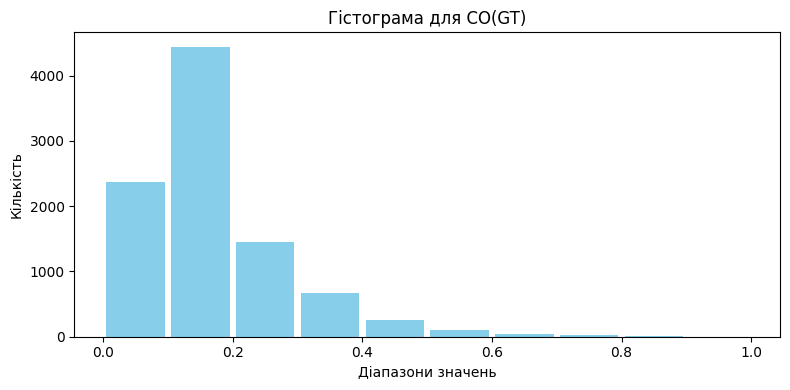

0.1434 c


In [26]:
start = time.time()
plt.figure(figsize=(8, 4))
plt.hist(df_norm['CO(GT)'], bins=10, color='skyblue', rwidth=0.9)
plt.title("Гістограма для CO(GT)")
plt.xlabel("Діапазони значень")
plt.ylabel("Кількість")
plt.tight_layout()
plt.show()
end = time.time()
print(f"{end - start:.4f} c")


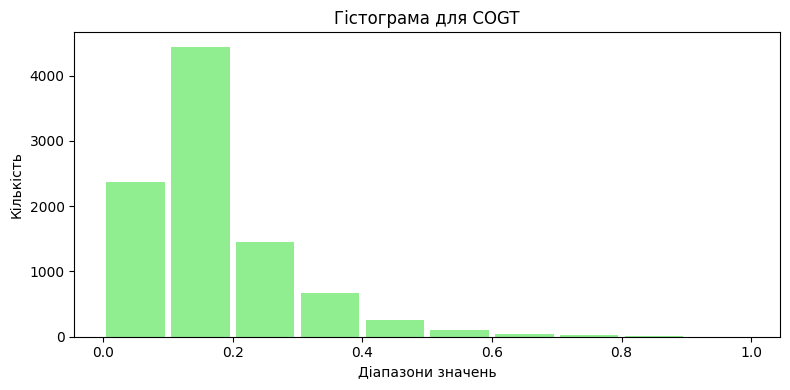

0.1435 c


In [27]:
start = time.time()
plt.figure(figsize=(8, 4))
plt.hist(arr_norm['COGT'], bins=10, color='lightgreen', rwidth=0.9)
plt.title("Гістограма для COGT")
plt.xlabel("Діапазони значень")
plt.ylabel("Кількість")
plt.tight_layout()
plt.show()
end = time.time()
print(f"{end - start:.4f} c")


Завдання №4. Графік залежності одного integer атрибута від іншого.

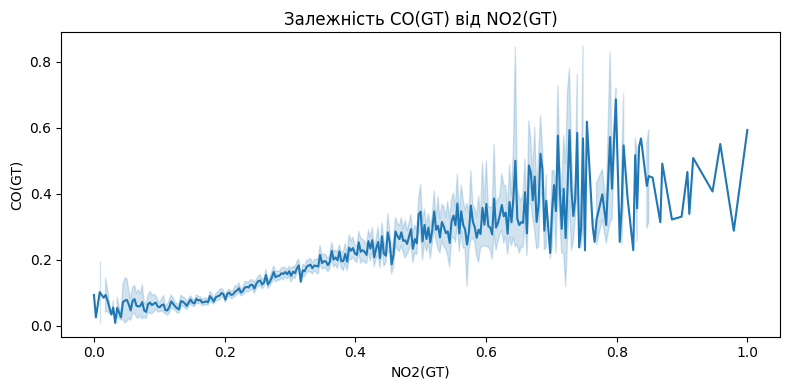

5.1998 c


In [28]:
start = time.time()
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_norm, x='NO2(GT)', y='CO(GT)')
plt.title("Залежність CO(GT) від NO2(GT)")
plt.xlabel('NO2(GT)')
plt.ylabel('CO(GT)')
plt.tight_layout()
plt.show()
end = time.time()
print(f"{end - start:.4f} c")


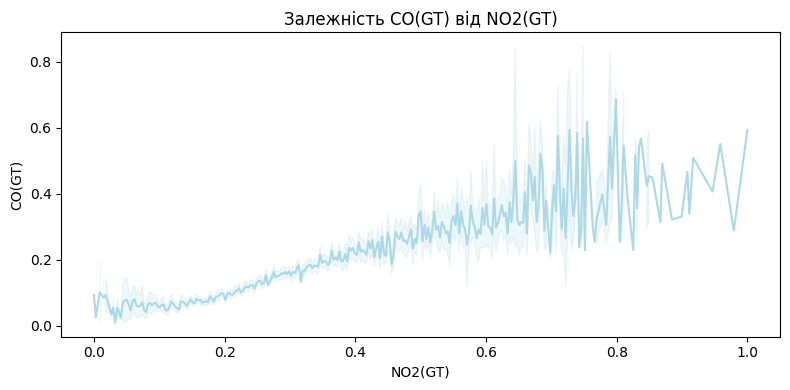

5.1859 с


In [29]:
start = time.time()
plt.figure(figsize=(8, 4))
sns.lineplot(x=arr_norm['NO2GT'], y=arr_norm['COGT'], color="lightblue")
plt.title(f"Залежність CO(GT) від NO2(GT)")
plt.xlabel('NO2(GT)')
plt.ylabel('CO(GT)')
plt.tight_layout()
plt.show()
end = time.time()
print(f"{end - start:.4f} с")


Завдання №5. Підрахунок коефіцієнтів Пірсона та Спірмена для двох integer атрибутів

In [30]:
start = time.time()
pearson_pandas, _ = pearsonr(df['NO2(GT)'], df['CO(GT)' ])
end = time.time() - start
print(f"== pandas ==\nПірсон: {pearson_pandas:.4f} ({end:.6f} c)")

start = time.time()
spearman_pandas, _ = spearmanr(df['NO2(GT)'], df['CO(GT)' ])
end = time.time() - start
print(f"Спірмен: {spearman_pandas:.4f} ({end:.6f} c)\n")

# == numpy ==
start = time.time()
pearson_numpy, _ = pearsonr(arr['NO2GT'], arr['COGT'])
end = time.time() - start
print(f"== numpy ==\nПірсон: {pearson_numpy:.4f} ({end:.6f} c)")

start = time.time()
spearman_numpy, _ = spearmanr(arr['NO2GT'], arr['COGT'])
end = time.time() - start
print(f"Спірмена: {spearman_numpy:.4f} ({end:.6f} c)")


== pandas ==
Пірсон: 0.6560 (0.001579 c)
Спірмен: 0.6692 (0.001834 c)

== numpy ==
Пірсон: 0.6560 (0.000905 c)
Спірмена: 0.6692 (0.001970 c)


Завдання №6. One Hot Encoding categorical атрибуту Time

In [31]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# == pandas ==
start = time.time()
encoded_pandas = encoder.fit_transform(df[['Time']])
df_encoded = pd.DataFrame(encoded_pandas, columns=encoder.get_feature_names_out(['Time']))
end = time.time() - start
print(f"== pandas == {end:.6f} c") 

# == numpy ==
start = time.time()
encoded_numpy = encoder.fit_transform(arr['Time'].reshape(-1, 1))
end = time.time() - start
print(f"== numpy == {end:.6f} c")



== pandas == 0.007108 c
== numpy == 0.010790 c


In [32]:
df_encoded

,Time_00.00.00,Time_01.00.00,Time_02.00.00,Time_03.00.00,Time_04.00.00,Time_05.00.00,Time_06.00.00,Time_07.00.00,Time_08.00.00,Time_09.00.00,...,Time_14.00.00,Time_15.00.00,Time_16.00.00,Time_17.00.00,Time_18.00.00,Time_19.00.00,Time_20.00.00,Time_21.00.00,Time_22.00.00,Time_23.00.00
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Завдання №7. Візуалізація багатовимірних даних

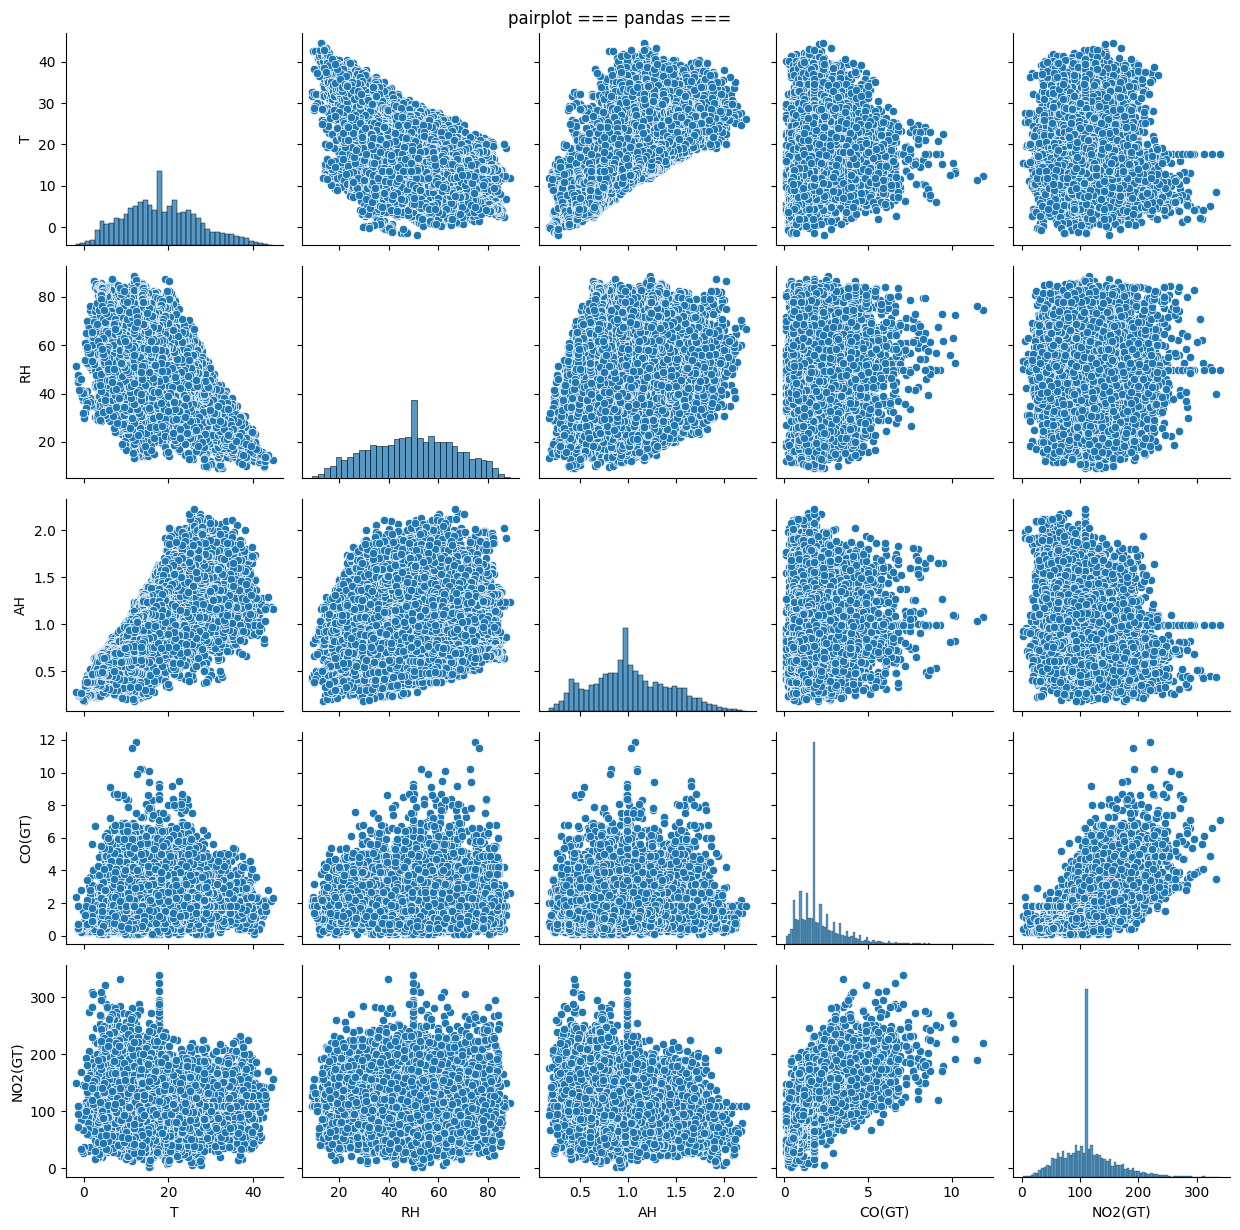

4.0789 c


In [33]:
# == pandas ==
start = time.time()
sns.pairplot(df[['T', 'RH', 'AH', 'CO(GT)', 'NO2(GT)']])
plt.suptitle("pairplot === pandas ===")
plt.tight_layout()
plt.show()
end = time.time()

print(f"{end - start:.4f} c")

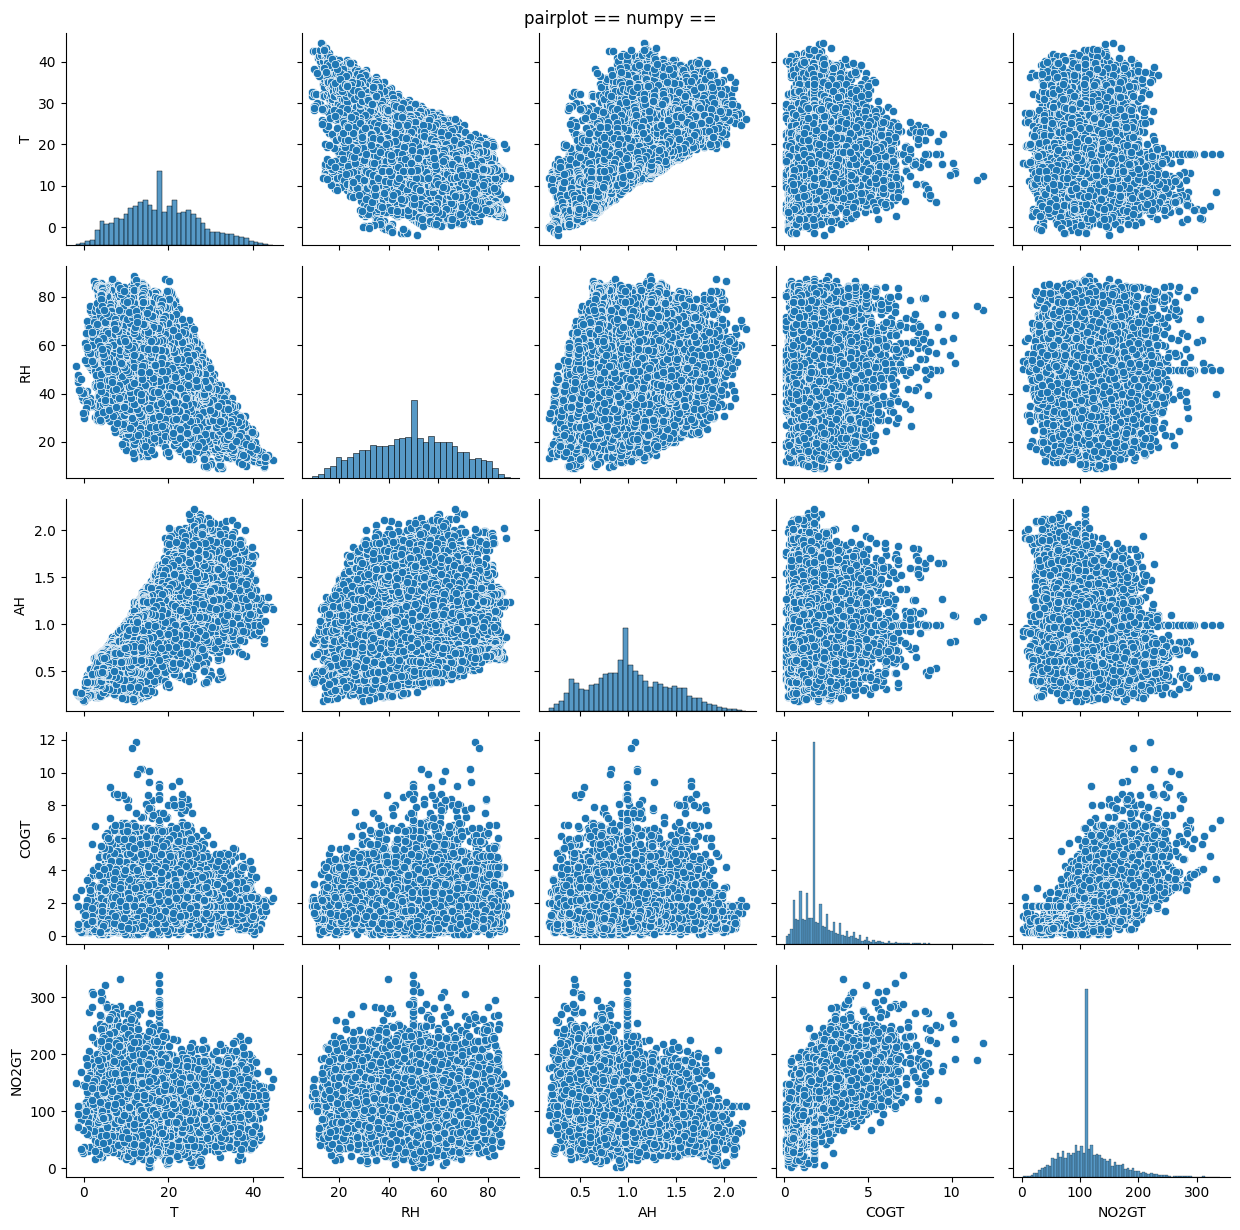

3.9230 c


In [36]:
start_np = time.time()
sns.pairplot(pd.DataFrame(arr[['T', 'RH', 'AH', 'COGT', 'NO2GT']]))
plt.suptitle("pairplot == numpy ==")
plt.tight_layout()
plt.show()

end_np = time.time()
print(f"{end_np - start_np:.4f} c")
